<a href="https://colab.research.google.com/github/CarlosSMWolff/Photon-Bundles/blob/main/1-Steady-state-and-spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary packages

In [1]:
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  ! pip install qutip

import numpy as np
from qutip import *

from numpy import sqrt, pi
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import spsolve
if qutip.settings.has_mkl:
    from qutip._mkl.spsolve import mkl_spsolve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Understanding the dressed qubit (nonlinear oscillator)

Our approach will consist on dressing the qubit states with the laser, enabling non-number conserving interactions with the cavity. Here, we will see that if $\Omega_q > U$, we will be seeing higher levels in the qubit. If we want to keep a simple description based on a qubit, $U$ will set a limit to the power with which we drive the qubit. We can still see interesting things for higher powers, but we loose the qubit description and the physics becomes messier.

In [2]:
Nqubit = 7
b = destroy(Nqubit)

def gen_H_qubit(params_H:list):
  # This function generates a Hamiltonian in the rotating frame of the drive.
  # Both qubit and cavity can be directly driven in this scheme 

  Delta_q, U, Omega_q = params_H
  H = (Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b + Omega_q*(b.dag()+b))
  return H

In [3]:
Omega_q_min = 0.; Omega_q_max = 200; nOmega = 100;
Omega_q_list = np.linspace(Omega_q_min, Omega_q_max, nOmega)

U = -100

In [4]:
eigen_Omega = np.asarray([gen_H_qubit([0., U, Omega_q]).eigenenergies() for Omega_q in Omega_q_list])
eigen_Omega.shape

(100, 7)

Here we see that for $\Omega_q \ll U$ (with U the red line), the states $|0\rangle$ and $|1\rangle$ are dressed, while the higher states stay pretty much the same.

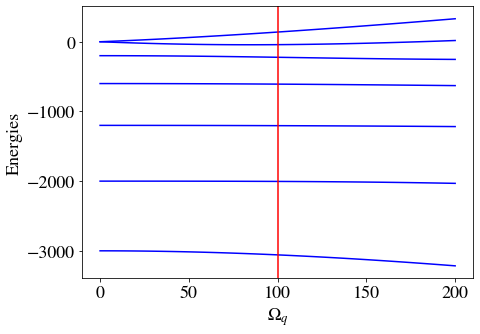

In [5]:
fig, ax = plt.subplots(figsize= (7,5))
for idx in range(Nqubit):
  ax.plot(Omega_q_list, eigen_Omega[:,idx], 'b-')
ax.set_xlabel("$\Omega_q$"); ax.set_ylabel("Energies")
ax.axvline(x=np.abs(U), color='red')
plt.show()

In [6]:
Omega_q = 10
vac_q = basis(Nqubit,0)

tini = 0.; tfin = 4*2*pi/Omega_q; nt = 1000; times = np.linspace(tini, tfin, nt)
H = gen_H_qubit([0., U, Omega_q])
                
result = mesolve(H, rho0 = vac_q,  tlist = times, c_ops = [])

In [7]:
def pop_time_index(idx, result):
  return [np.squeeze(np.abs(psi[idx])**2) for psi in result.states]

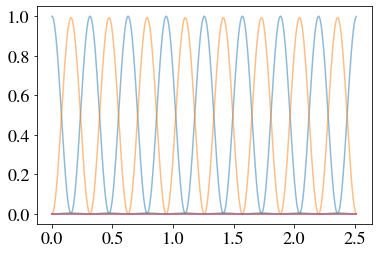

In [8]:
for idx in range(Nqubit):
  plt.plot(times, pop_time_index(idx,result), alpha = 0.5)

plt.show()

# Definitions of system and useful functions

We will define a cavity with annihilation operator $\hat a$, and a qubit given by a cavity with annihilation operator $\hat b$ and a Kerr-type nonlinearity $U$.

In [2]:
Ncav = 3     # Truncation number in the cavity 
Nqubit = 2    # Trunction number in the qubit-cavity

a = tensor(destroy(Ncav), qeye(Nqubit))
b = tensor(qeye(Ncav), destroy(Nqubit))

vac = tensor(basis(Ncav,0), basis(Nqubit,0))

We define a function to create the following Hamiltonian, in the rotating frame of a coherent drive:

$ \hat H = \Delta_a \hat a^\dagger \hat a + \Delta_q \hat b ^\dagger \hat b 
+ U \hat b^\dagger \hat b^\dagger \hat b \hat b + g(\hat a^\dagger \hat b + \hat a \hat b^\dagger )  + \Omega_a (\hat a + \hat a^\dagger) + \Omega_q(\hat b + \hat b^\dagger)$

We assume:


1.  Qubit described by Kerr cavity
2.   Jaynes-Cummings interaction




## Useful functions

In [141]:
def gen_Hamiltonian(params:list):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  H = (Delta_a * a.dag()*a + Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b +
       g*(a.dag()*b + b.dag()*a) 
  + Omega_a*(a.dag()+a) + Omega_q*(b.dag()+b))
  return H

def gen_Liouv(params: list):
  H = gen_Hamiltonian(params)
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return liouvillian(H, c_ops)

def compute_spectrum_qutip(params: list, omega_grid, op):
  Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi  = params

  H = gen_Hamiltonian(params)
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return spectrum(H, omega_grid, c_ops, op.dag(), op)

def Spectrum(omega_list, liouv, Gamma, a):
  # Gamma is the filter linewidth
  liouvM=liouv.data
  h2 = liouv.shape[0] # Hilbert size ^2
  id = sp.identity(h2)
  rho_ss = steadystate(liouv)
  rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))
  aM = a.data
  h = aM.shape[0]

  eigen_vecs=liouv.eigenstates()
  E = np.transpose(np.reshape(
      np.array([eigen_vecs[1][i].full() for i in range(h2)]), 
      (h2,h2)))
  Einv = np.linalg.inv(E)
  EinvTr = Einv.T
  eigvals = eigen_vecs[0]
  Einvrhs=EinvTr@rhs

  Elist = E, Einvrhs, rhs, eigvals 


  spectrumgrid = np.asarray(
      [-np.real(
      (aM@(
          ((
          E@np.transpose(
              1/(eigvals - 1j*omega - Gamma)*EinvTr)          
          )@rhs).reshape((h,h))
          )).trace()
      )/pi for omega in omega_list] 
  )
  return spectrumgrid

# Definition of system parameters

These are the parameters that I will leave fixed for the rest of the notebook. Notice that, in the bundling regime, the following relations must hold:

$$ g \ll \Delta_a=\Omega_q \ll U  $$

Explanation:



1.   $g \ll \Delta_a$ is required so that first-order qubit-atom coupling effects are well out of resonance. This way we are sure that **only photon pairs are exchanged** between cavity and dressed qubit at the two-photon resonance $\Omega_q=\Delta_a$.
2.   $ \Omega_q \ll U  $ is required to keep the two-level system approximation. This condition could be relaxed, but the results become more complicated to interpret. 



In [153]:
# System parameters in MHz

U = -100 
g = 1 

kappa = 0.5
gamma_phi = 0.5
gamma_q = 0.05

Delta_a = 10*g
Delta_q = 0

# Scheme #1

*   **Driving**: Qubit
*   **Output measured**: Cavity

Experiment: The Rabi frequency of the qubit driving $\Omega_q$ is increased and the spectrum of emission from the cavity is recorded. A resonant feature should be observed when the cavity frequency is exactly between the central Mollow peak and one of the Mollow sidebands, i.e., when $\Omega_q =\Delta_a$




In [198]:
# Define range of Rabi frequencies
Omega_q_min, Omega_q_max, nOmega = 0.1, 15*g, 100
Omega_q_grid = np.linspace(Omega_q_min, Omega_q_max, nOmega)
Omega_a = 0

# Grid of frequencies for the spectrum measurement 
omega_min = -2*Omega_q_max; omega_max = -omega_min; nomega = 200
omega_grid = np.linspace(omega_min, omega_max, nomega)

Gamma = 0.05

params_list = [[Delta_q, Delta_a, g, U, Omega_a, Omega_q, kappa, gamma_q, gamma_phi] for Omega_q in Omega_q_grid]

In [205]:
spectrum_array = np.asarray(
    [Spectrum(omega_grid, gen_Liouv(params), Gamma, a) for params in tqdm(params_list)]
)

idx_cav = np.argmin(np.abs(omega_grid - Delta_a))
spectrum_at_cavity = spectrum_array[:,idx_cav]


  7%|▋         | 7/100 [00:02<00:30,  3.06it/s]

KeyboardInterrupt: ignored

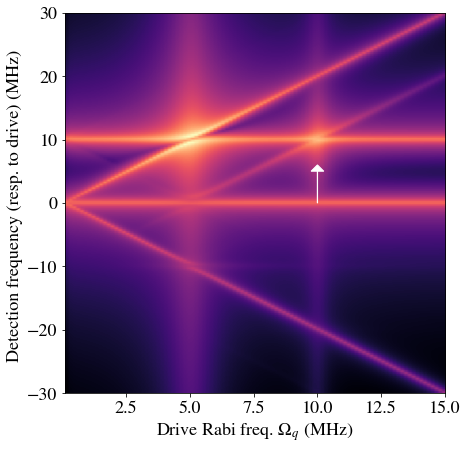

In [200]:
fig, ax = plt.subplots(figsize= (7,7))
ax.imshow(np.flip((np.log10(np.abs(np.flip(spectrum_array.T,axis=1))))), extent = [Omega_q_min,Omega_q_max, omega_min,omega_max],aspect = 'auto', cmap = 'magma')
ax.arrow(Delta_a, 0, 0, 5, width=0.01, head_width=0.5, head_length=1, color='w')
ax.set_box_aspect(1.)
ax.set_ylabel('Detection frequency (resp. to drive) (MHz) ')
ax.set_xlabel('Drive Rabi freq. $\Omega_q$ (MHz)')

plt.show()